<h2> Base Model Neural Network</h2>

In [113]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, PIL
from PIL import Image
import cv2
import random

import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from keras import losses
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,RandomizedSearchCV

import sklearn.metrics as metrics

from __future__ import print_function
print(tf.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
trDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 224, 224, 3), (4264,), (1067, 224, 224, 3), (1067,)


Showing 449 index image, It is 1.0


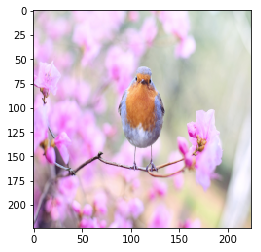

Showing 859 index image, It is 0.0


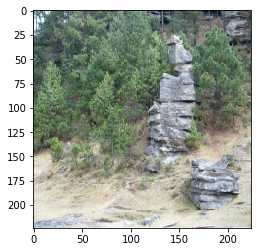

Showing 418 index image, It is 1.0


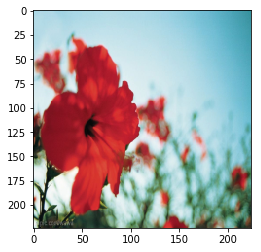

Showing 982 index image, It is 0.0


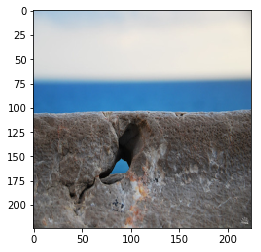

Showing 1028 index image, It is 0.0


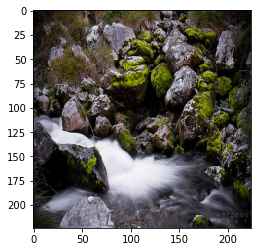

In [0]:
# Randomly show 5 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat  = trDatOrg.reshape(4264, 150528)
tsDat = tsDatOrg.reshape(1067, 150528)

trDat  = trDat.astype('float32')
tsDat  = tsDat.astype('float32')

trDat /= 255
tsDat /= 255


# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg,2)
tsLbl       = to_categorical(tsLblOrg,2)

In [0]:
# X_train forms the test images, and y_test forms the test labels
X_train, y_train, X_test,y_test = trDat, trLbl,tsDat,tsLbl

<h2> Define Model </h2>

In [93]:
model = Sequential()
model.add(Dense(128, kernel_initializer='uniform',activation='relu', input_shape=X_train.shape[1:])) 
model.add(Dense(64, kernel_initializer='uniform',activation='relu'))
model.add(Dense(num_classes, kernel_initializer='uniform', activation='softmax'))
  
model = createBaseModel()

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 150528)]          0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               19267712  
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 258       
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


<h2> Training the Model </h2>

<p>I train the model with batch size of 64 and 20 epochs on both training and validation data. </p>

In [94]:
# Fit the model
# This is where the training starts
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1)

Epoch 1/20
4264/4264 [==============================] - 3s 661us/sample - loss: 15.9664 - acc: 0.5492
Epoch 2/20
4264/4264 [==============================] - 3s 639us/sample - loss: 7.0266 - acc: 0.5718
Epoch 3/20
4264/4264 [==============================] - 3s 644us/sample - loss: 4.5957 - acc: 0.5994
Epoch 4/20
4264/4264 [==============================] - 3s 644us/sample - loss: 5.6571 - acc: 0.5835
Epoch 5/20
4264/4264 [==============================] - 3s 639us/sample - loss: 4.6351 - acc: 0.6133
Epoch 6/20
4264/4264 [==============================] - 3s 643us/sample - loss: 2.8958 - acc: 0.6351
Epoch 7/20
4264/4264 [==============================] - 3s 641us/sample - loss: 3.6087 - acc: 0.5999
Epoch 8/20
4264/4264 [==============================] - 3s 644us/sample - loss: 3.5792 - acc: 0.6058
Epoch 9/20
4264/4264 [==============================] - 3s 640us/sample - loss: 1.3469 - acc: 0.7017
Epoch 10/20
4264/4264 [==============================] - 3s 650us/sample - loss: 1.7426 - 

In [95]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.652519762732487
Test accuracy: 0.5763824


In [96]:
# Make classification on the test dataset
predicts    = model.predict(X_test)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

# the labels for the classfication report
labelname   = ['flower', 'non-flower']


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 57.64%
              precision    recall  f1-score   support

      flower     0.5556    0.0220    0.0424       454
  non-flower     0.5767    0.9869    0.7280       613

    accuracy                         0.5764      1067
   macro avg     0.5661    0.5045    0.3852      1067
weighted avg     0.5677    0.5764    0.4363      1067

[[ 10 444]
 [  8 605]]


In [97]:
#show shape
trDat_reshape  = trDatOrg.reshape(4264, 150528)
print(trDat_reshape)

[[245 245 247 ...  37  44  29]
 [255 255 255 ...  34  20   4]
 [ 42  48  38 ...  42  50  35]
 ...
 [ 74  59  24 ...  28  31  16]
 [  0   1   0 ...   0   0   0]
 [201 193 181 ... 149 137 127]]


<h2> Hyperparameter Tuning with SGD </h2>

In [0]:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd =tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

In [132]:
model_sgd = Sequential()
model_sgd.add(Dense(128, activation=tf.nn.relu, kernel_initializer='uniform', input_shape=X_train.shape[1:])) 
model_sgd.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform'))
model_sgd.add(Dropout(0.1))
model_sgd.add(BatchNormalization())
model_sgd.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

model_sgd.summary()

# compile the model
model_sgd.compile(loss='mean_squared_error', 
                  optimizer=sgd, 
                  metrics=['acc'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 128)               19267712  
_________________________________________________________________
dense_122 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_________________________________________________________________
dense_123 (Dense)            (None, 2)                 130       
Total params: 19,276,354
Trainable params: 19,276,226
Non-trainable params: 128
_________________________________________________________________


In [131]:
# Fit the model
batch_size = 64

history1 = model1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 4264 samples, validate on 1067 samples
Epoch 1/60
4264/4264 [==============================] - 3s 742us/sample - loss: 0.3024 - acc: 0.8731 - val_loss: 0.9915 - val_acc: 0.6532
Epoch 2/60
4264/4264 [==============================] - 3s 737us/sample - loss: 0.2203 - acc: 0.9139 - val_loss: 1.0719 - val_acc: 0.6654
Epoch 3/60
4264/4264 [==============================] - 3s 748us/sample - loss: 0.1503 - acc: 0.9493 - val_loss: 0.9473 - val_acc: 0.6485
Epoch 4/60
4264/4264 [==============================] - 3s 744us/sample - loss: 0.0870 - acc: 0.9803 - val_loss: 1.1500 - val_acc: 0.6870
Epoch 5/60
4264/4264 [==============================] - 3s 741us/sample - loss: 0.0686 - acc: 0.9887 - val_loss: 1.0343 - val_acc: 0.6842
Epoch 6/60
4264/4264 [==============================] - 3s 747us/sample - loss: 0.0782 - acc: 0.9843 - val_loss: 1.4560 - val_acc: 0.6542
Epoch 7/60
4264/4264 [==============================] - 3s 742us/sample - loss: 0.0806 - acc: 0.9817 - val_loss: 1.1159 - va

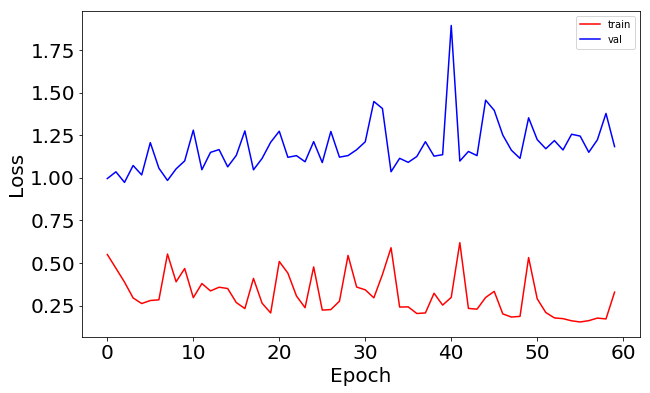

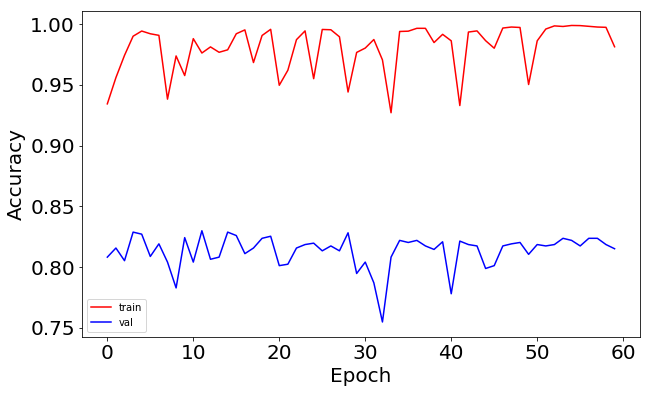

In [133]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history1.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history1.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history1.history['acc']), 'r', label='train')
ax.plot(np.sqrt(history1.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [140]:
score_sgd = model_sgd.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_sgd[0])
print('Test accuracy:', score_sgd[1])

Test loss: 0.24351742299449924
Test accuracy: 0.5576382


<h2> Learning Rate Adjustment </h2>

In [149]:
epochs = 50
learning_rate = 0.01 # initial learning rate
decay_rate = 0.1
momentum = 0.9

# define the optimizer function
sgd =  tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

input_dim = X_train.shape[1]
num_classes = 2
batch_size = 64

# build the model
exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
exponential_decay_model.compile(loss='categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['acc'])
                                
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(X_test, y_test))

Train on 4264 samples, validate on 1067 samples
Epoch 1/50
4264/4264 [==============================] - 3s 735us/sample - loss: 0.6727 - acc: 0.5891 - val_loss: 0.6500 - val_acc: 0.6298
Epoch 2/50
4264/4264 [==============================] - 3s 604us/sample - loss: 0.6506 - acc: 0.6234 - val_loss: 0.6370 - val_acc: 0.6279
Epoch 3/50
4264/4264 [==============================] - 3s 602us/sample - loss: 0.6403 - acc: 0.6391 - val_loss: 0.6334 - val_acc: 0.6467
Epoch 4/50
4264/4264 [==============================] - 3s 602us/sample - loss: 0.6364 - acc: 0.6412 - val_loss: 0.6302 - val_acc: 0.6326
Epoch 5/50
4264/4264 [==============================] - 3s 604us/sample - loss: 0.6321 - acc: 0.6426 - val_loss: 0.6271 - val_acc: 0.6429
Epoch 6/50
4264/4264 [==============================] - 3s 604us/sample - loss: 0.6306 - acc: 0.6414 - val_loss: 0.6255 - val_acc: 0.6467
Epoch 7/50
4264/4264 [==============================] - 3s 604us/sample - loss: 0.6290 - acc: 0.6433 - val_loss: 0.6248 - va

<p>  Better Results :run with learning rate = 0.5 & momentum = 0.8 </p>

In [145]:
score_decay = exponential_decay_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_decay[0])
print('Test accuracy:', score_decay[1])

Test loss: 0.571618966946785
Test accuracy: 0.68603563


<p> Better Results: run with learning rate = 0.01 & momentum = 0.8 </p>

In [147]:
score_decay = exponential_decay_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_decay[0])
print('Test accuracy:', score_decay[1])

Test loss: 0.6484431890873789
Test accuracy: 0.61105907
